In [1]:
import pandas as pd
import pandas_profiling as pdp
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

%matplotlib inline

In [2]:
#pandasのカラムが100まで見れるようにする
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

In [3]:
# データの読み込み
df_train = pd.read_csv('../.kaggle/sample_data/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../.kaggle/sample_data/house-prices-advanced-regression-techniques/test.csv')

In [4]:
#サンプルから欠損値と割合、データ型を調べる
def missing_table(df):
    null_val = df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending=False)
    percent = 100*null_val/len(df)
    na_col_list = df.isnull().sum()[df.isnull().sum()>0].index.tolist()
    list_type = df[na_col_list].dtypes.sort_values(ascending=False)
    missing_table = pd.concat([null_val, percent, list_type], axis=1)
    missing_table_len = missing_table.rename(columns={0:'欠損値',1:'%',2:'type'})
    return missing_table_len.sort_values(by=['欠損値'], ascending=False)


In [5]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

In [6]:
df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp

In [7]:
#訓練データとテストデータの区別のために、印(フラグ)をつけて結合
df_train['DataIs'] = 'train'
df_test['DataIs'] = 'test'
df_test['SalePrice'] = 99999999999
print('訓練データサイズ：', df_train.shape)
print('テストデータサイズ：', df_test.shape)


訓練データサイズ： (1460, 82)
テストデータサイズ： (1459, 82)


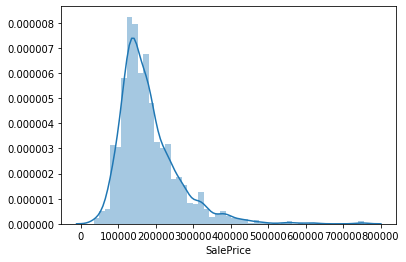

In [8]:
#目的変数の分布変換
#SalePriceがどんな分布か、ヒストグラムで確認する
#数件の大豪邸がヒストグラムを左に詰めている状況 外れ値的な住宅価格データある
sns.distplot(df_train['SalePrice'])

In [9]:
#統計量で確認する
#四分位数を見ると、75%点からmaxへの差が大きい。
#LotArea(住宅面積)、GrLivArea(地上の居住面積)、SalePriceのきなみ75%から乖離
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [10]:
#欠損値の確認
#Nan:その設備がないことの意味
#数値0：その設備がないことの意味
#プールを持たない家がほとんど→プールを持つ大豪邸(とても値段が高い家)がある
#ヒストグラムが右に裾が広いことが考えられる
print('train \n',missing_table(df_train))
print('test \n',missing_table(df_test))

train 
                欠損値          %     type
PoolQC        1453  99.520548   object
MiscFeature   1406  96.301370   object
Alley         1369  93.767123   object
Fence         1179  80.753425   object
FireplaceQu    690  47.260274   object
LotFrontage    259  17.739726  float64
GarageFinish    81   5.547945   object
GarageQual      81   5.547945   object
GarageType      81   5.547945   object
GarageYrBlt     81   5.547945  float64
GarageCond      81   5.547945   object
BsmtFinType2    38   2.602740   object
BsmtExposure    38   2.602740   object
BsmtFinType1    37   2.534247   object
BsmtQual        37   2.534247   object
BsmtCond        37   2.534247   object
MasVnrArea       8   0.547945  float64
MasVnrType       8   0.547945   object
Electrical       1   0.068493   object
test 
                欠損値          %     type
PoolQC        1456  99.794380   object
MiscFeature   1408  96.504455   object
Alley         1352  92.666210   object
Fence         1169  80.123372   object
FireplaceQ

C:\Users\odash\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


外れ値の確認

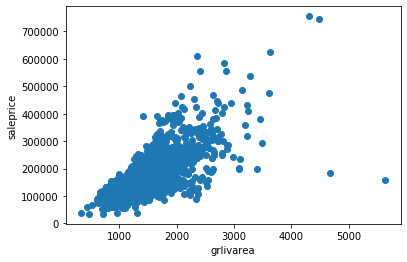

In [11]:
#家賃は、家の面積に関係するという仮説
#家賃は家の面積に比例して増加していることがうかがえるが、右下に広いのに安い家ある
fig, ax = plt.subplots()
ax.scatter(x=df_train['GrLivArea'], y=df_train['SalePrice'])
plt.ylabel('saleprice')
plt.xlabel('grlivarea')
plt.show()

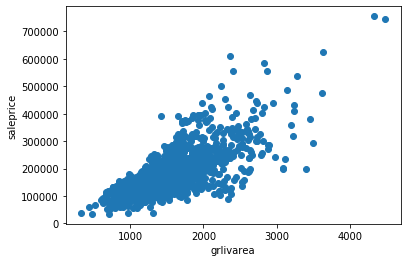

In [12]:
#GrLivAreaーSalePriceの右下の値を除外する
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

#外れ値が消えたか確認
fig, ax = plt.subplots()
ax.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel('saleprice')
plt.xlabel('grlivarea')
plt.show()

mu = 180932.92 and sigma = 79467.79


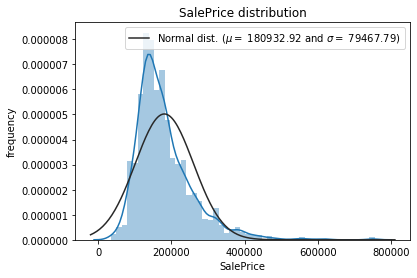

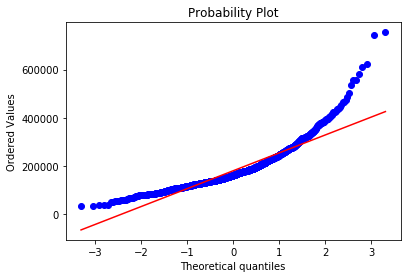

In [13]:
#目的変数のSalePriceを可視化する。
#正規分布に従っているかを見る
#fit=norm:正規分布を描く
sns.distplot(df_train['SalePrice'], fit=norm) 

#正規分布の平均値と標準偏差を抜き出す
(mu, sigma) = norm.fit(df_train['SalePrice'])
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

#分布図を表示
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('frequency')
plt.title('SalePrice distribution')

#Q-Qプロット：得られたデータと理論分布を比較し、類似度を調べる。類似していればプロットした点が直線に並ぶ
#SalePriceが正規分布に似ているか見てみる
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()
#右裾に広い分布であり、正規分布に近いため、より正規分布に近づける

目的変数を対数変換し、疑似的な正規分布のようにする

mn = 12.02 and sigma = 0.40


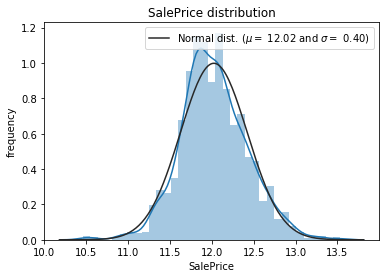

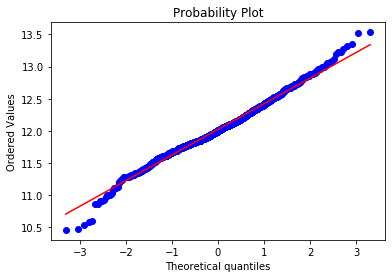

In [14]:
#log1pをつかうlog(x+1)。log0は定義できないため
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

#分布をみてみる
sns.distplot(df_train['SalePrice'], fit=norm)

#平均値と標準偏差を抜き出し
(mu, sigma) = norm.fit(df_train['SalePrice'])
print('mn = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

#分布図の描写のための凡例など
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('frequency')
plt.title('SalePrice distribution')

#Q-Qプロットを描く
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

特徴量エンジニアリング

In [15]:
#訓練データとテストデータを結合
df_all = pd.concat([df_train, df_test], axis=0, sort=False).reset_index(drop=True) # drop=trueで、元あったindexを削除

In [16]:
df_all.shape

(2917, 82)

In [17]:
#id,SalePrice,DataIsをいったん削除
df_tmp = df_all.copy()
df_tmp.drop(['Id', 'SalePrice', 'DataIs'], axis=1, inplace=True)

In [18]:
df_tmp.shape

(2917, 79)

欠損値の確認

In [19]:
#欠損値がそのデータの全体に対する割合を調べる
df_tmp_na = (df_tmp.isnull().sum() / len(df_tmp)) * 100
df_tmp_na = df_tmp_na.drop(df_tmp_na[df_tmp_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'missing ratio':df_tmp_na})
missing_data

,missing ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


Text(0, 0.5, 'percent of missing values')

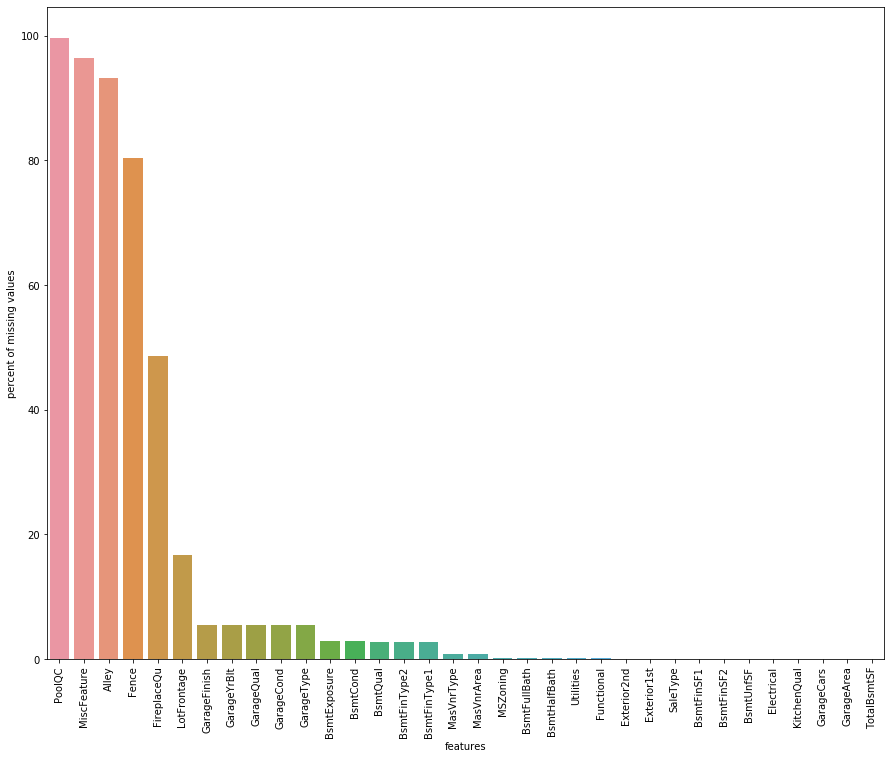

In [20]:
#欠損値を可視化する
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=df_tmp_na.index, y=df_tmp_na)
plt.xlabel('features')
plt.ylabel('percent of missing values')

相関マップの表示

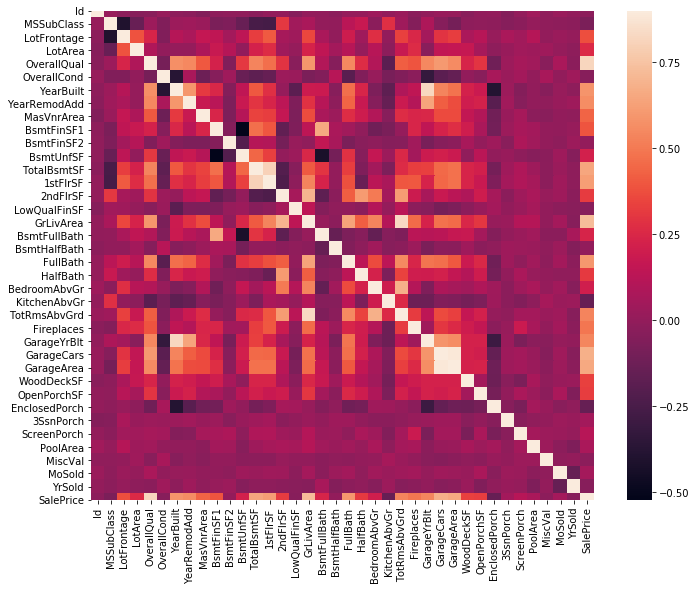

In [21]:
#SalePriceとその他特徴量がどの程度、相関の関係にあるのかヒートマップを描く
corrmat = df_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
#家の評価や建築年、フロア面積やガレージ関連に関係がありそう？

欠損値の補完

In [22]:
#PoolQC:データなしは、プールなしの意味。Noneで補完
df_tmp['PoolQC'] = df_tmp['PoolQC'].fillna('None')

#MiscFeature:データなしは、特別な場所がない意味。Noneで補完
df_tmp['MiscFeature'] = df_tmp['MiscFeature'].fillna('None')

#Alley:データなしは路地への接続なし。Noneで補完
df_tmp['Alley'] = df_tmp['Alley'].fillna('None')

#Fence:データなしはフェンスなし。None補完
df_tmp['Fence'] = df_tmp['Fence'].fillna('None')

#FireplaceQu:データなしは、暖炉なしNone補完
df_tmp['FireplaceQu'] = df_tmp['FireplaceQu'].fillna('None')

#LotFrontage:住宅に面している道路の面積は、近隣の住宅も同様な面積であると予測され、
#近隣のLotFontageの中央値で欠損値を埋める。Neighborhoodを用いる
df_tmp['LotFrontage'] = df_tmp.groupby('Neighborhood')['LotFrontage'].transform(
                                        lambda x: x.fillna(x.median()))

#GarageType,GarageFinish,GarageQual,GarageCond:データなしは設備なし。None補完
for col in ['GarageType','GarageFinish','GarageQual','GarageCond']:
    df_tmp[col] = df_tmp[col].fillna('None')
    
#GarageYrBlt,GrageArea,GarageCars:データなしは設備なし。数値データなので0補完
for col in ['GarageYrBlt','GarageArea','GarageCars']:
    df_tmp[col] = df_tmp[col].fillna(0)
    
#BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath:
#データなしは設備なし。数値データなので0補完
for col in ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']:
    df_tmp[col] = df_tmp[col].fillna(0)
    
#BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2:
#データなしは設備なし。None補完
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_tmp[col] = df_tmp[col].fillna('None')

#MasVnrArea,MasVnrType:データなしは、設備なし。Noneと0で補完
df_tmp['MasVnrType'] = df_tmp['MasVnrType'].fillna('None')
df_tmp['MasVnrArea'] = df_tmp['MasVnrArea'].fillna(0)

#MSZoning:RLが最も多いので、RLで補完する
df_tmp['MSZoning'] = df_tmp['MSZoning'].fillna(df_tmp['MSZoning'].mode()[0])

#Utilities:ほとんどAllPubなのでモデルづくりに影響せず、削除
df_tmp = df_tmp.drop(['Utilities'], axis=1)

#Functional:データなしはダントツで多い典型的な機能とする。Typで補完
df_tmp['Functional'] = df_tmp['Functional'].fillna(df_tmp['Functional'].mode()[0])

#Electrical:データなしは、ダントツで多い標準設備、SBrkrで補完。
df_tmp['Electrical'] = df_tmp['Electrical'].fillna(df_tmp['Electrical'].mode()[0])

#KitchenQual:データなしは、平均的である意味のTAとして補完。最頻値でもある
df_tmp['KitchenQual'] = df_tmp['KitchenQual'].fillna(df_tmp['KitchenQual'].mode()[0])

#Exterior1st,Exterior2nd：外装の様子。データなしは最頻値で補完。VinySd
df_tmp['Exterior1st'] = df_tmp['Exterior1st'].fillna(df_tmp['Exterior1st'].mode()[0])
df_tmp['Exterior2nd'] = df_tmp['Exterior2nd'].fillna(df_tmp['Exterior2nd'].mode()[0])

#SaleType:売られ方は最頻値で補完。WD
df_tmp['SaleType'] = df_tmp['SaleType'].fillna(df_tmp['SaleType'].mode()[0])

#MSSubClass:データなしは、建物の判別クラスなし。整数を使ったカテゴリ変数のためNone補完
df_tmp['MSSubClass'] = df_tmp['MSSubClass'].fillna('None')

In [23]:
df_tmp['Electrical'].value_counts()

SBrkr    2670
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [24]:
#欠損値の確認
df_tmp_na = (df_tmp.isnull().sum()) / len(df_tmp)  * 100
df_tmp_na = df_tmp_na.drop(df_tmp_na[df_tmp_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'missing ratio': df_tmp_na})
missing_data

,missing ratio


特徴量エンジニアリング

In [25]:
#整数で入力されているカテゴリ変数を文字列に変換
#MSSubClass:建物の判別クラス、
df_tmp['MSSubClass'] = df_tmp['MSSubClass'].astype(str)

#OverallCond:家の全体的な評価10段階
df_tmp['OverallCond'] = df_tmp['OverallCond'].astype(str)

#売れた年と月は大小におおきな影響を出したくないのでカテゴリ化
df_tmp['YrSold'] = df_tmp['YrSold'].astype(str)
df_tmp['MoSold'] = df_tmp['MoSold'].astype(str)

In [26]:
#カテゴリ変数をラベルエンコーディングによってダミー変数化
from sklearn.preprocessing import LabelEncoder
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

for col in cols:
    lb = LabelEncoder()
    lb.fit(list(df_tmp[col].values)) #fitするにはpandas DataFrameからnp.arrayに変換
    df_tmp[col] = lb.transform(list(df_tmp[col].values)) #transformするにはpandas DataFrameからnp.arrayに変換

#shapeをみてみる
print('shape df_tmp: {}'.format(df_tmp.shape))

shape df_tmp: (2917, 78)


新たな特徴量の追加

In [27]:
#１F床面積や２F床面積、地下面積が、ヒートマップで価格と相関ありそうなので、全床面積をつくる
df_tmp['TotalSF'] = df_tmp['TotalBsmtSF'] + df_tmp['1stFlrSF'] + df_tmp['2ndFlrSF']


数値特徴量の歪度

In [28]:
#数値型の特徴量の歪度(skew)を確認。正規分布からどのくらい差があるか
#歪度が正：分布は右裾に広い
#歪度が負：分布は左裾に広い
numeric_feats = df_tmp.dtypes[df_tmp.dtypes != 'object'].index

#すべての数値型の歪度を確認
skewed_feats = df_tmp[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print('skew in numerical features:')
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness

skew in numerical features:


,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


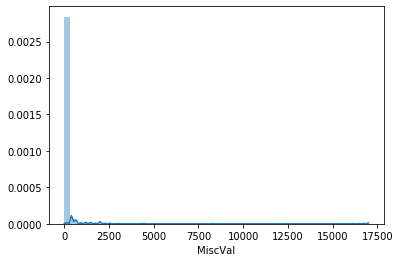

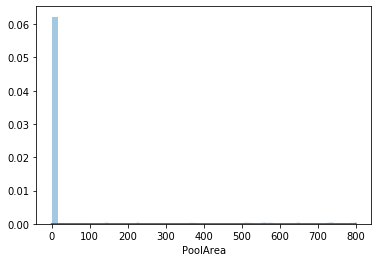

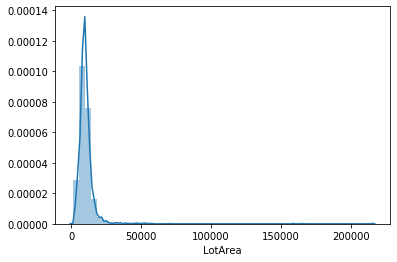

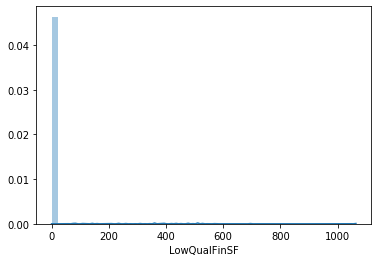

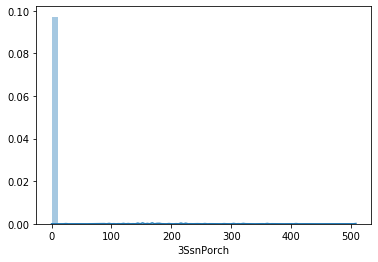

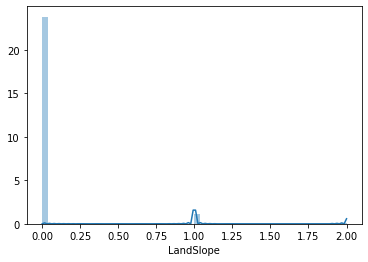

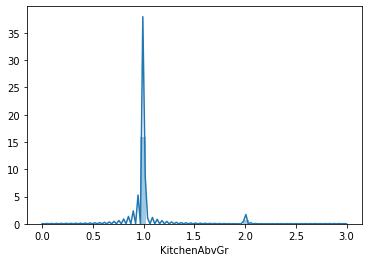

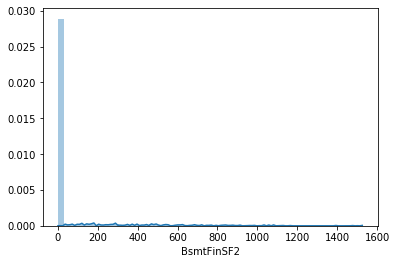

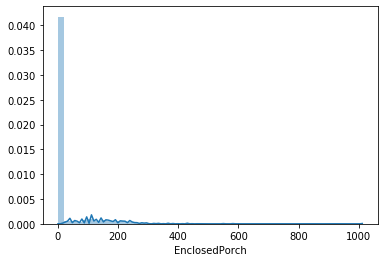

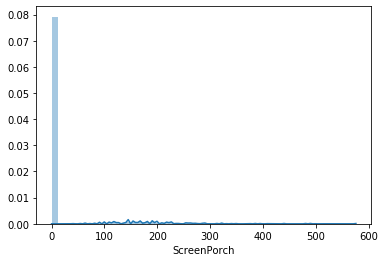

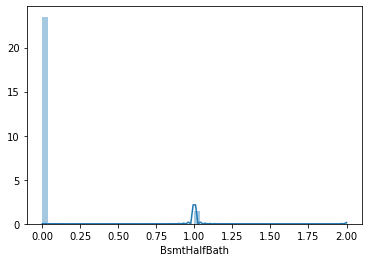

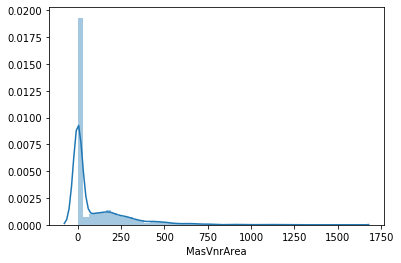

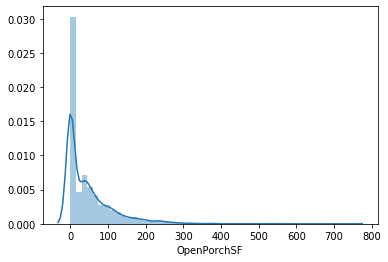

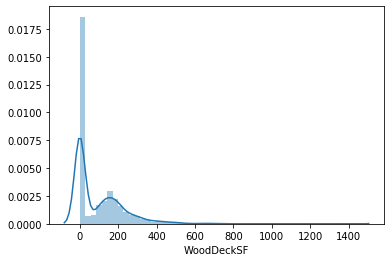

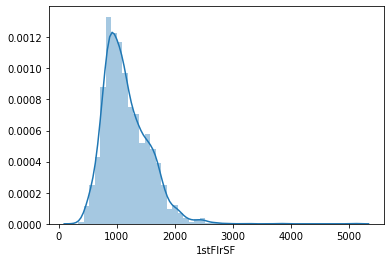

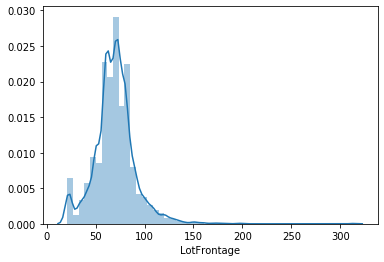

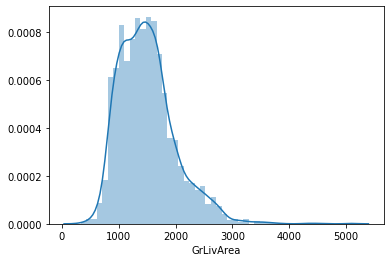

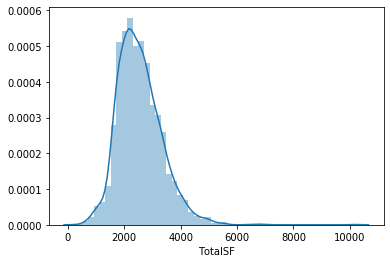

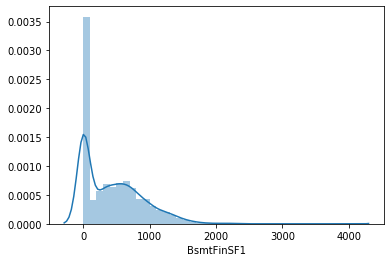

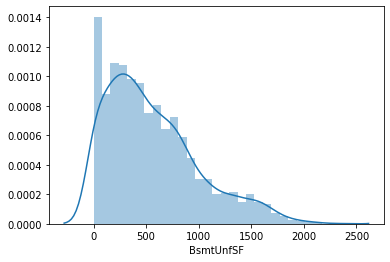

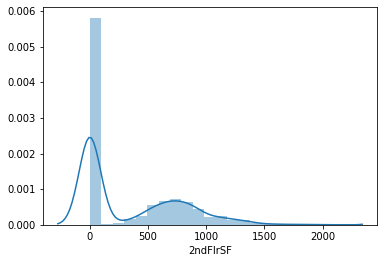

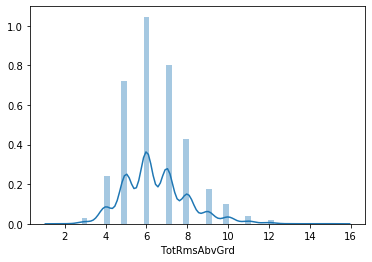

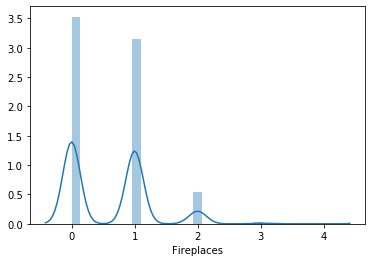

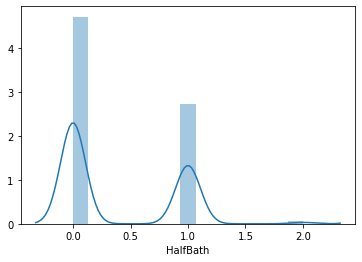

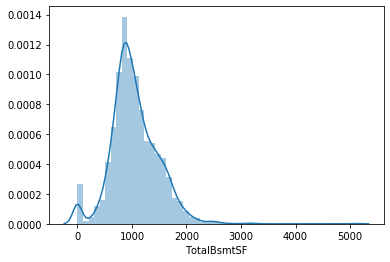

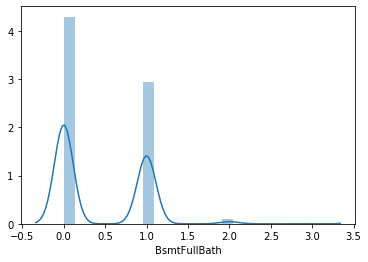

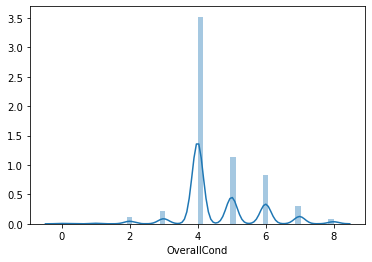

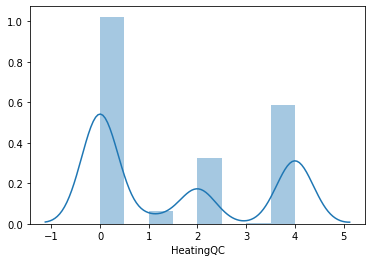

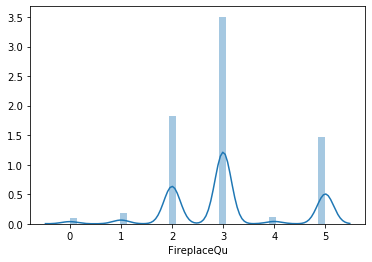

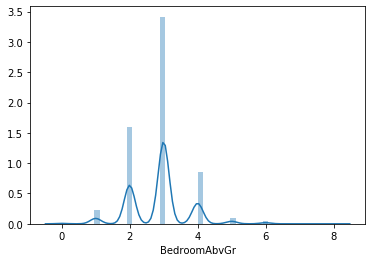

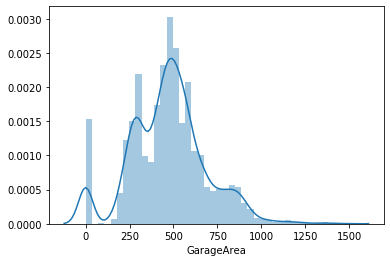

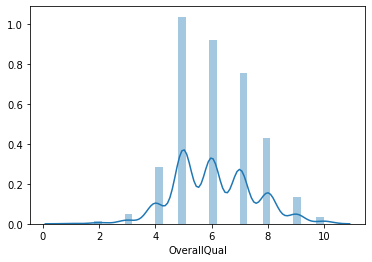

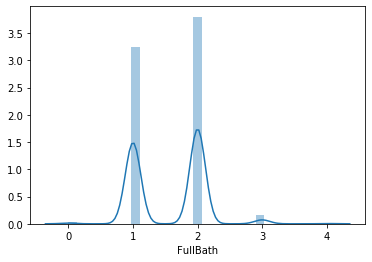

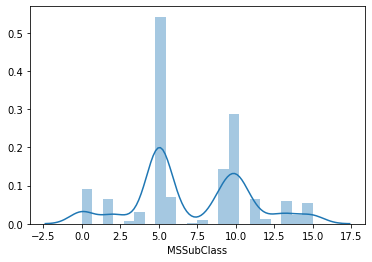

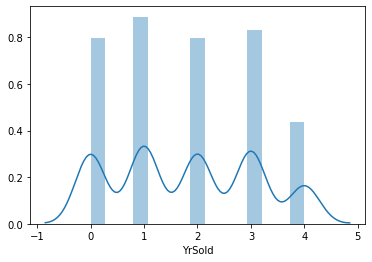

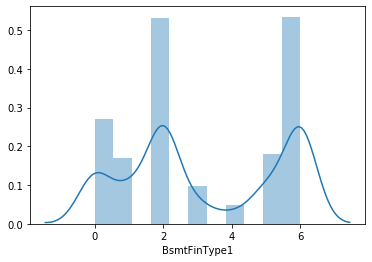

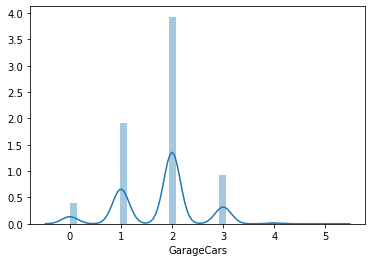

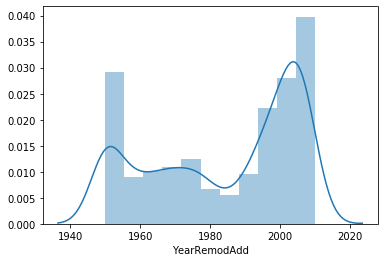

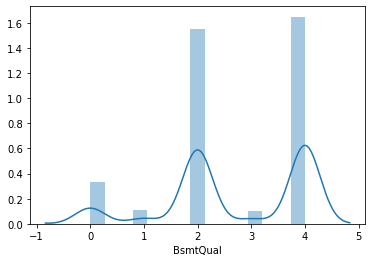

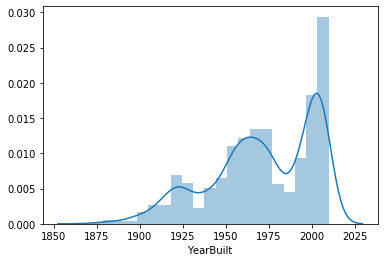

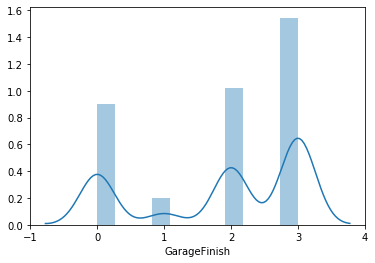

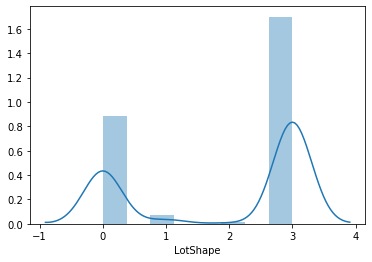

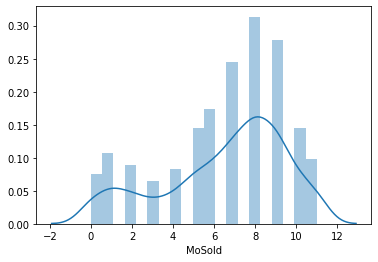

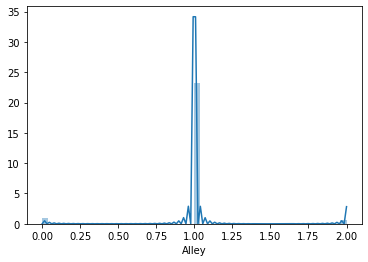

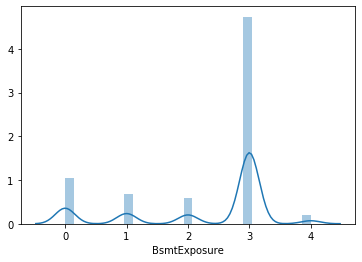

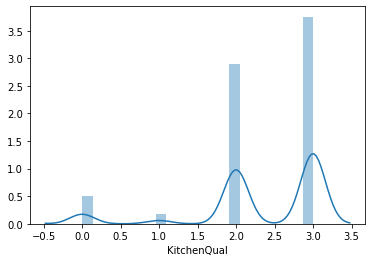

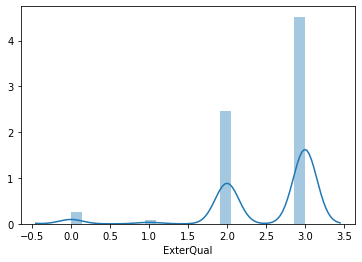

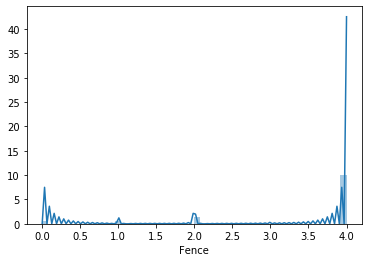

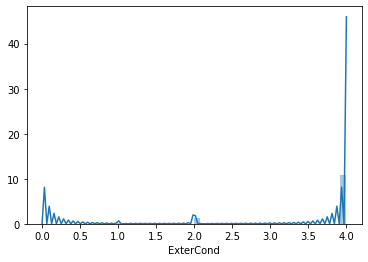

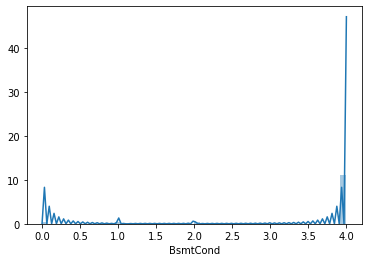

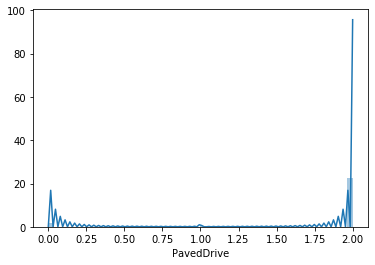

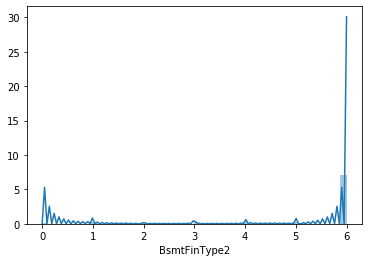

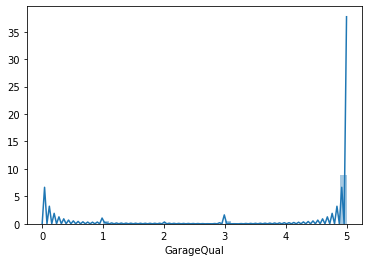

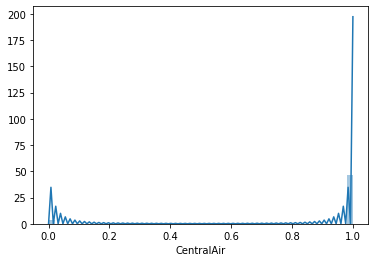

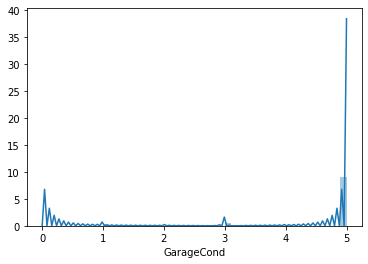

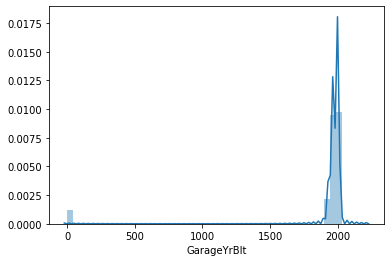

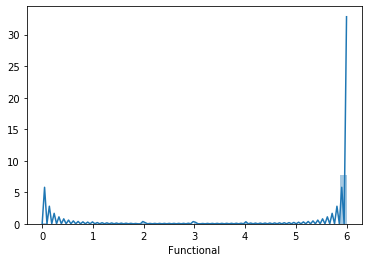

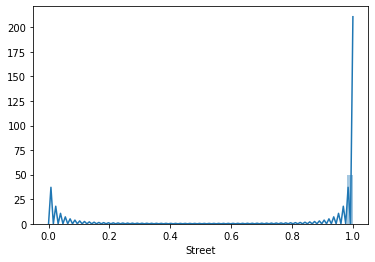

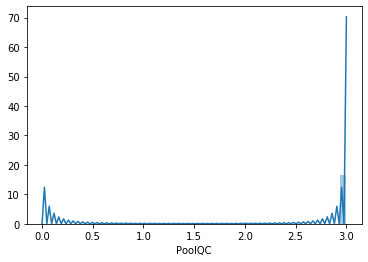

In [29]:
#fig, axes = plt.subplots(3,3, figsize=(8,8))

for col in skewness.index:
    sns.distplot(df_tmp[col], label=col)
    plt.show()

Box Cox変換を行う

In [30]:
#Box Cox変換：変数のスケールを変えて分布を正規分布の形に変える
#λ=0は定期gできないので1+xを用いる
#歪度の絶対値が0.75以上のものを変換
skewness = skewness[abs(skewness) > 0.75]
print('{} skewed numerical features to Box Cox transform'.format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df_tmp[feat] = boxcox1p(df_tmp[feat], lam)

59 skewed numerical features to Box Cox transform


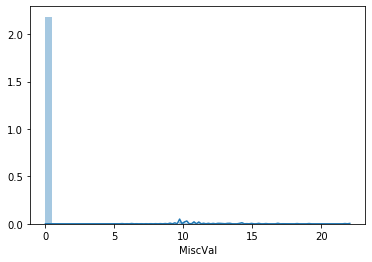

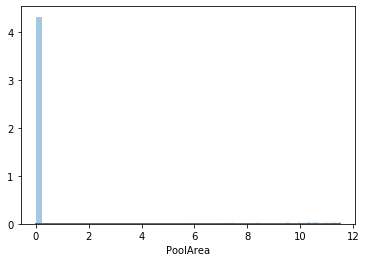

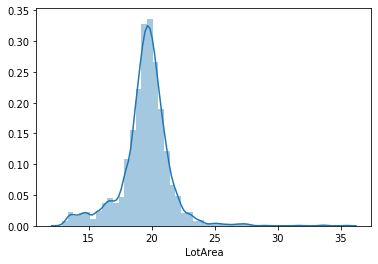

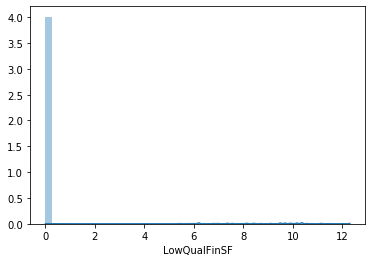

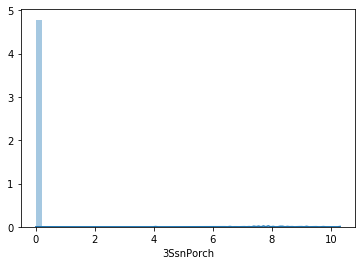

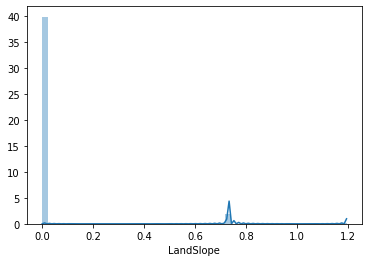

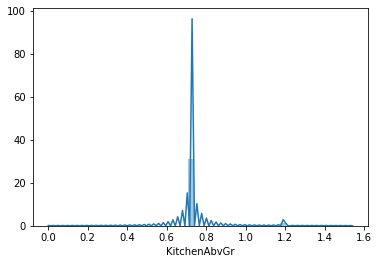

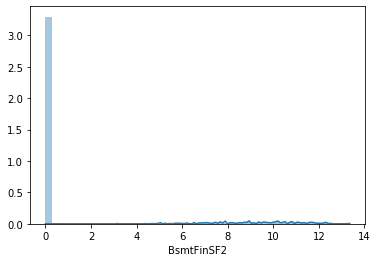

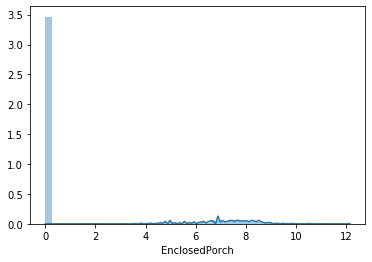

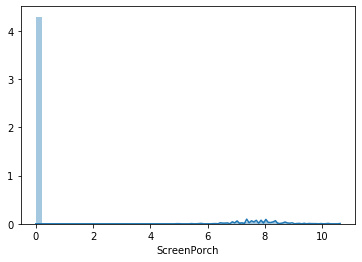

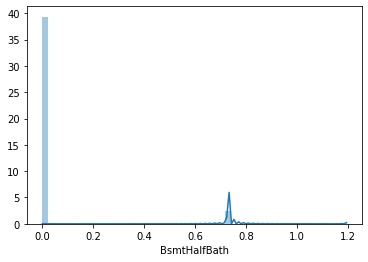

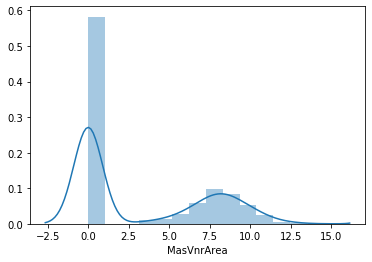

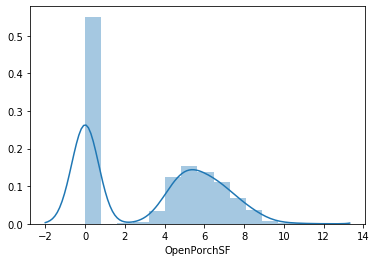

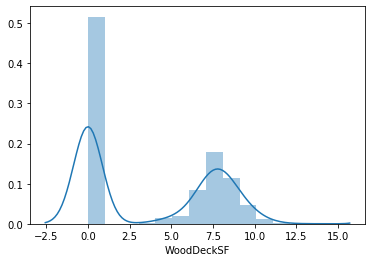

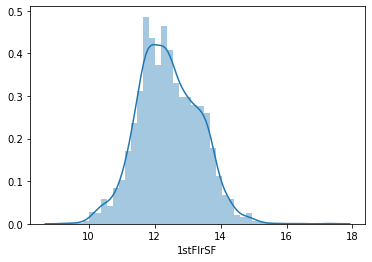

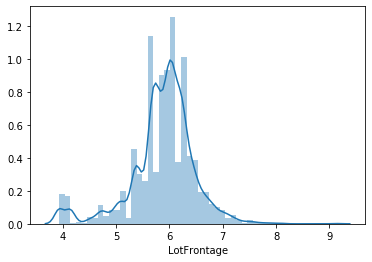

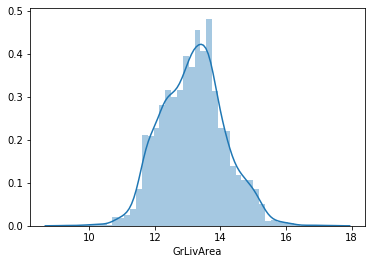

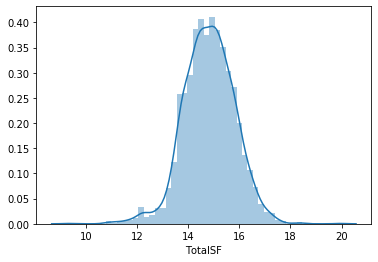

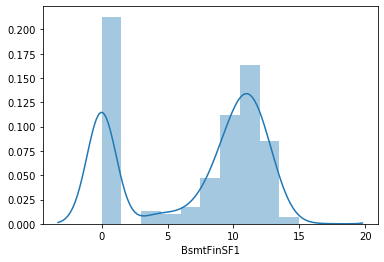

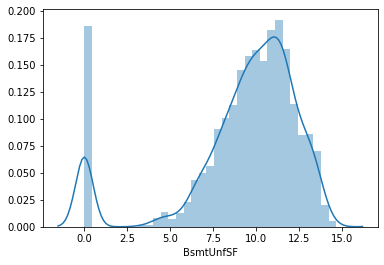

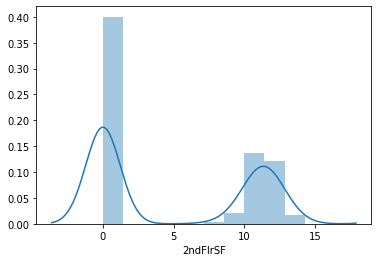

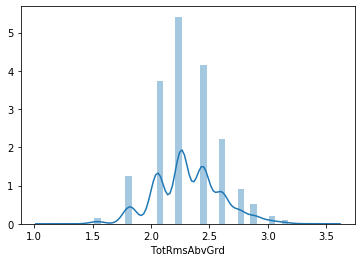

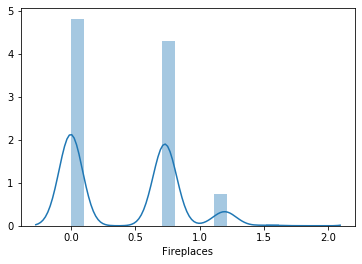

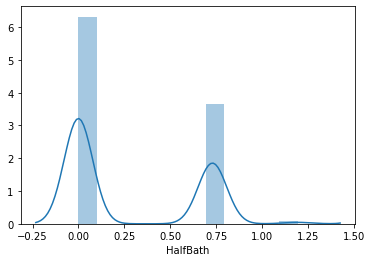

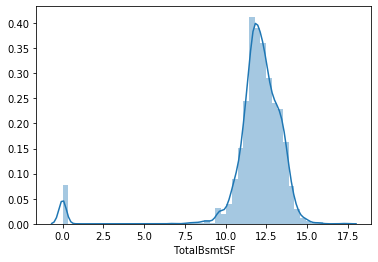

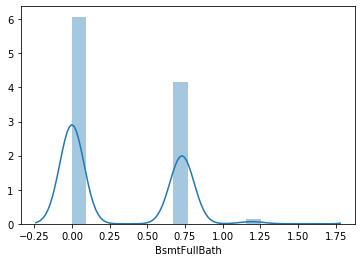

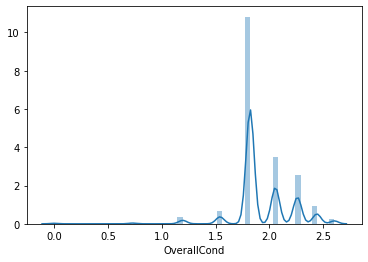

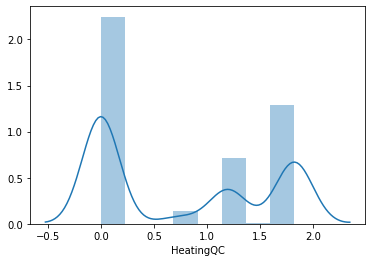

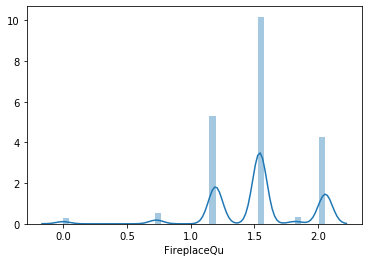

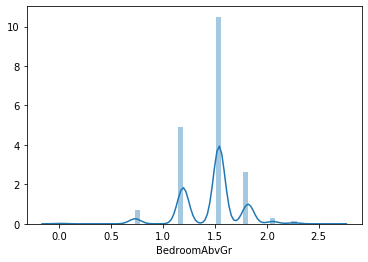

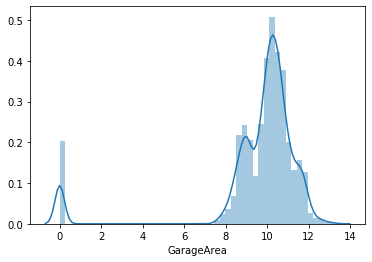

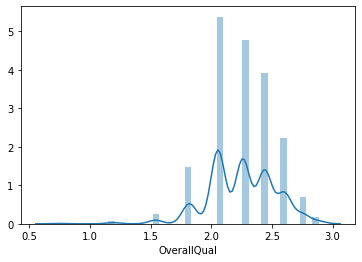

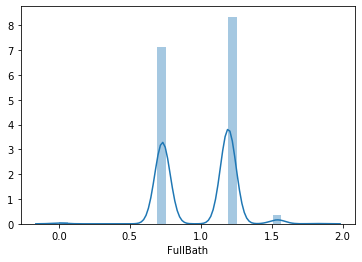

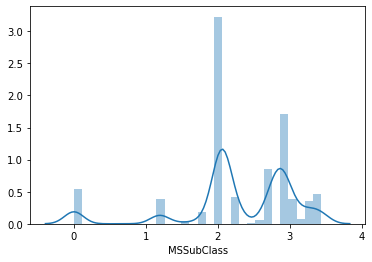

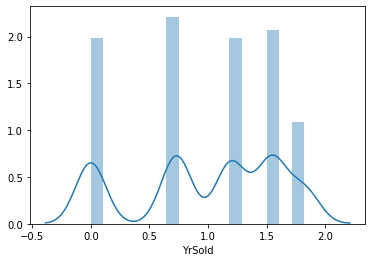

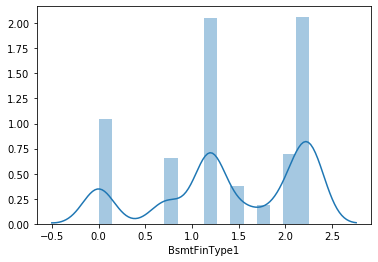

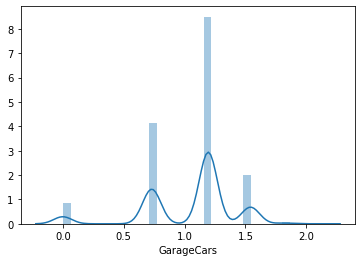

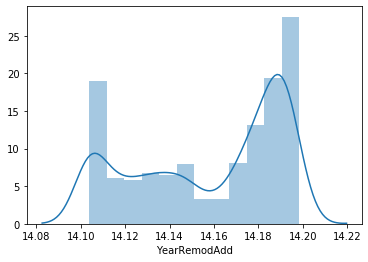

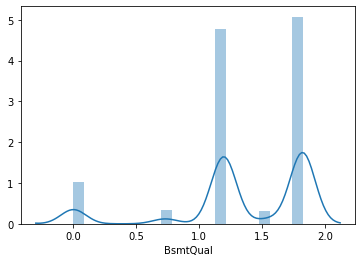

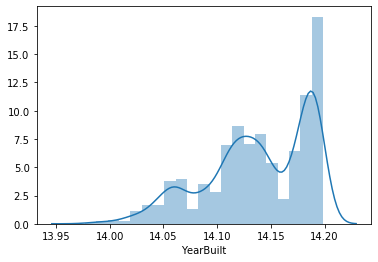

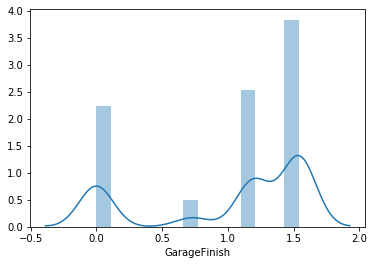

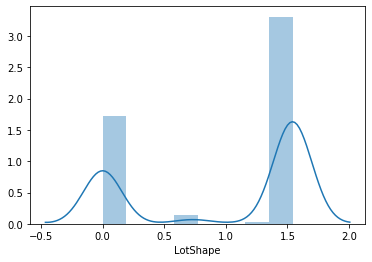

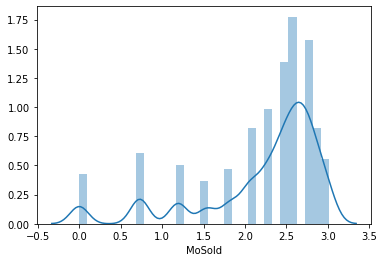

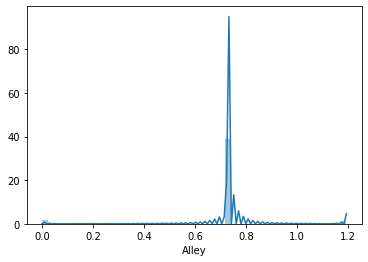

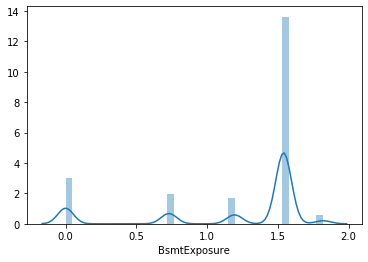

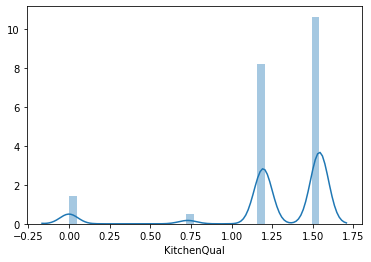

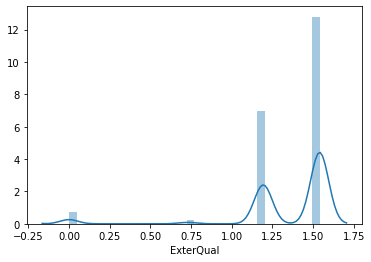

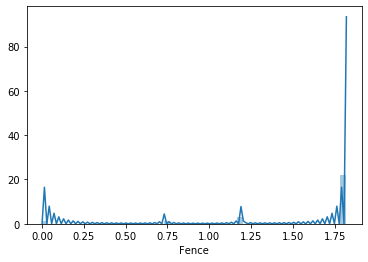

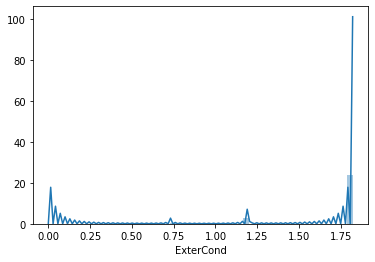

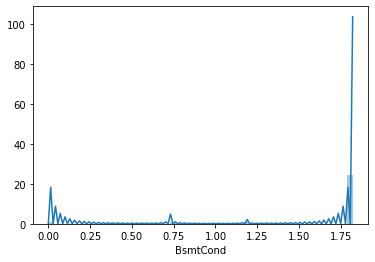

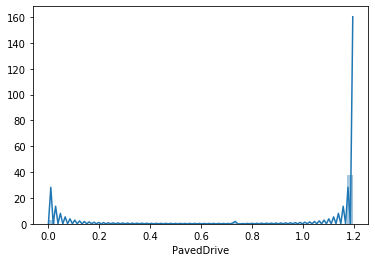

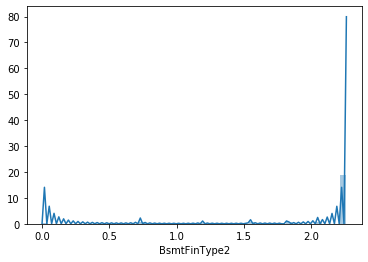

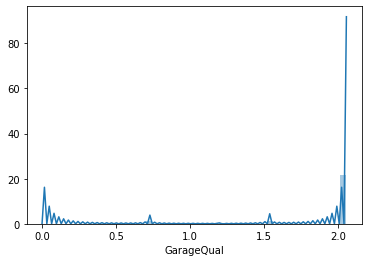

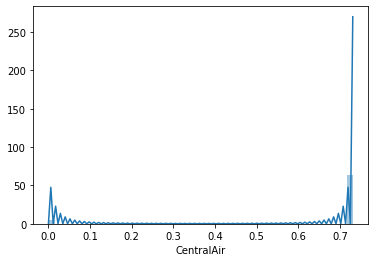

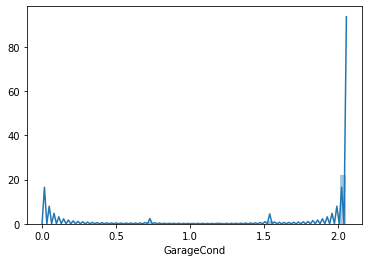

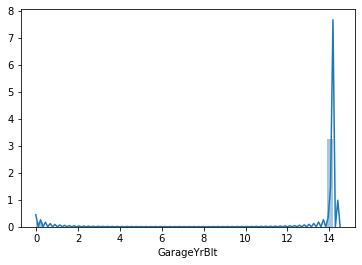

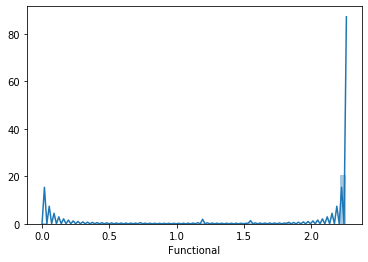

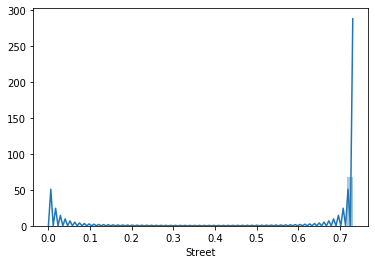

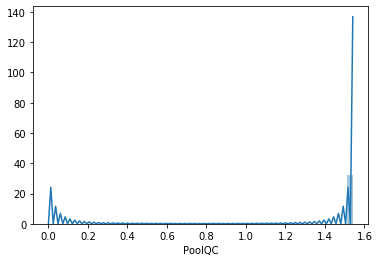

In [31]:
#boxcox変換の結果を可視化
for col in skewness.index:
    sns.distplot(df_tmp[col], label=col)
    plt.show()

カテゴリ変数のダミー変数化

In [32]:
df_tmp = pd.get_dummies(df_tmp)
print(df_tmp.shape)

(2917, 220)


訓練データとテストデータの生成

In [33]:
train = df_tmp[:len(df_train)]
test = df_tmp[len(df_train):]

In [34]:
print(train.shape)
print(test.shape)

(1458, 220)
(1459, 220)


In [35]:
y_train = df_train['SalePrice']
y_test = df_test['SalePrice']

モデリング

In [36]:
#いろいろな方法でモデル作成してみる
#基本モデルと、モデルの組み合わせを試していく
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

交差検証を行う関数を作製

In [37]:
#k分割交差検証を行う
#分割数は5
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train.values,
                                    scoring='neg_mean_squared_error', cv=kf))
    return(rmse)

基本的なモデルについて試す

In [38]:
#Lasso回帰モデル:特徴量をいくつか0にする
#特徴量に繊細なため、標準化を行ってみる
#alpha=0.0005でひとまず考える
lasso = make_pipeline(MinMaxScaler(), Lasso(alpha=0.0004, random_state=1))

In [39]:
#Elastic Net回帰：Ridge回帰とLasso回帰の折衷案。L2正則化項からL1正則化項を引く
#Lassoにおいて特徴量の選択数に制限があるのを改善
#l1_ratio:1に近いほどほぼL1(Lasso)。0だとL2(Ridge)
ENet = make_pipeline(MinMaxScaler(), ElasticNet(alpha=0.0004, l1_ratio=0.9, random_state=3))

In [40]:
#Kernel Ridge回帰：カーネル法を回帰問題に適用。
#カーネル法：生データに非線形写像を施して、それを新しいデータとみなして線形な手法を施す
#グネグネした生データを、グネグネした空間にてうまいことならべると、その空間では直線になっているのでは。がアイデア
#ぐねぐねした空間でまっすぐにした直線を元の空間に戻すと、グネグネした線となっている。
#線形手法でぐねぐね線を作る
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [41]:
#Gradient Boosting回帰：勾配ブｰスティング。損失関数の勾配を用いた
#ブｰスティング：弱学習器(決定木など)の学習を逐次的に行い、強学習器に導くアルゴリズム
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                  max_depth=4, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10, 
                                  loss='huber', random_state=5)

In [53]:
#主成分分析を使ったサポートベクター回帰モデル:特徴量を減らす
#特徴量に繊細なため、標準化を行ってみる c=20,epsilon=0.008,gamma=0.0003
#alpha=0.0005でひとまず考える
from sklearn.svm import SVR
from sklearn.decomposition import PCA 
svr_pca = make_pipeline(MinMaxScaler(), PCA(n_components=200), SVR(kernel='linear', C=20, epsilon=0.008, gamma=0.0003))

In [43]:
#XGBoost

In [44]:
#LightGBM

基本的なモデルのスコア

In [45]:
#Lasso回帰
score = rmsle_cv(lasso)
print('Lasso score:{:.4f} ({:.4f})'.format(score.mean(), score.std()))

Lasso score:0.1115 (0.0076)


In [46]:
#Elastic Net回帰
score = rmsle_cv(ENet)
print('ElasticNet score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

ElasticNet score: 0.1115 (0.0076)


In [47]:
#カーネルRidge回帰
score = rmsle_cv(KRR)
print('Kernel Ridge score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)


In [54]:
#主成分分析をつかったサポートベクター回帰
score = rmsle_cv(svr_pca)
print('SVR with PCA score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

SVR with PCA score: 0.1174 (0.0100)


In [49]:
# サポートベクター回帰のハイパーパラメータのチューニング
from sklearn.model_selection import GridSearchCV
#標準化
scaler = MinMaxScaler()
scaler.fit_transform(train,y_train)


params_cnt = 20
params = {"C":np.logspace(0,21,params_cnt), "epsilon":np.logspace(0,1,params_cnt), 'gamma':np.logspace(0,1,params_cnt)}
gridsearch = GridSearchCV(SVR(), params, cv=5, scoring="r2", return_train_score=True)
gridsearch.fit(train, y_train)
print("C, εのチューニング")
print("最適なパラメーター =", gridsearch.best_params_)
print("精度 =", gridsearch.best_score_)
print()

C, εのチューニング
最適なパラメーター = {'C': 1.0, 'epsilon': 7.847599703514611, 'gamma': 1.0}
精度 = -0.006762686364510897



In [286]:
#Gradient Boosting回帰：勾配ブｰスティング。
score = rmsle_cv(GBoost)
print('Lasso pca score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Lasso pca score: 0.1167 (0.0083)


## アンサンブル学習
基本モデルの積層(スタッキングモデルの作成)-モデル平均まで

In [287]:
#複数のモデルを積層させ、平均をとる
#モデルの積層と平均をとるクラス
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    #データに適合されるために、元のモデルのクローン(複製)を定義
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        #複製したモデルの配列をそれぞれfitさせる
        for model in self.models_:
            model.fit(X, y)
        #fitした複製モデルを返す 
        return self
        
    #fitした複製モデルの予測predictとその結果の平均meanを行う
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) #1次元配列を重ねて二次元配列にしたものの平均

In [293]:
#スコア平均をみてみる
averaged_models = AveragingModels(models = [KRR, svr_pca, GBoost, ENet])

score = rmsle_cv(averaged_models)
print('averaged base models score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

averaged base models score: 0.1086 (0.0085)


基本モデルの積層(スタッキングモデルの作成)

- メタモデル(第1のモデルによる予測値を取りまとめるモデル)による、スタッキングモデルで作成されたデータの予測
- 各基本モデルでの予測値が、メタモデルの予測に使われる新たなデータセットとなる

In [294]:
#基本モデルを積層させ平均したデータを、メタモデルで予測
#積層モデルを平均したものを、メタモデルで予測させるクラス
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    #基本モデルとメタモデルの複製を作る
    #各モデルをfitする
    #k分割交差検証を行う
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        #複製された基本モデルで訓練データを予測する際に、
        #メタデータの予測に使わなれない基本モデルでの予測結果(out of fold prediction)ができる
        #これらは0にしておく(データの行数×モデル数(列数))
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models): #モデルとそのインデックス番号を送る
            #訓練データと検証データに分ける
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        #基本データでk分割交差検証実施＋out of fold predictionを0にして作成した予測データセットを
        #新しい特徴量としてメタデータに学習させる
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    #すべての基本モデルで予測を行い予測値の平均値で新たな特徴量を作る
    #メタモデルで新たに作成された特徴量で予測をする
    def predict(self, X):
        meta_featrues = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) 
            for base_models in self.base_models_
        ])
        return self.meta_model_.predict(meta_featrues)

In [295]:
#メタモデルによるスコア平均を見てみる
stacked_averaged_models = StackingAveragedModels(base_models = [KRR, svr_pca, GBoost, ENet],
                                                meta_model=lasso)

score = rmsle_cv(stacked_averaged_models)
print('stacking averaged models score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

stacking averaged models score: 0.1080 (0.0077)


In [77]:
#結果の出力
#Lasso
#提出用データ

averaged_models.fit(train, y_train)
test_SalePrice = pd.DataFrame(np.exp(averaged_models.predict(test)), columns=['SalePrice'])
test_Id = pd.DataFrame(df_test, columns=['Id'])
df_rg = pd.concat([test_SalePrice, test_Id], axis=1)
df_rg.to_csv('../.kaggle/sample_data/house-prices-advanced-regression-techniques/submission_ls.csv', index=False)

In [296]:
#アンサンブル学習：メタモデル結果の出力
#Lasso
#提出用データ

stacked_averaged_models.fit(train.values, y_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
test_SalePrice = pd.DataFrame()
test_SalePrice['SalePrice'] = stacked_pred
test_Id = pd.DataFrame(df_test, columns=['Id'])
df_rg = pd.concat([test_SalePrice, test_Id], axis=1)
df_rg.to_csv('../.kaggle/sample_data/house-prices-advanced-regression-techniques/submission_ls.csv', index=False)